# Projects in Machine Learning and AI (RPI Fall 2021)
### Homework 4 (100 points)
## Sequence Models

You need to perform the following tasks for this homework:
In your project, you will pick a dataset and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).

In [7]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.python.framework import ops
ops.reset_default_graph()

Sequence models are very important in applications that require the analysis of input data as a continuous correlated stream instead of as discrete, unrelated entities. Among the different types of artificial neural networks used in present-day AI applications, feedforward neural networks are the most common. I am using financial stocks data from the New York Stock Exchange Dataset, as the time series data is sequential in nature and would be a good fit to apply sequential models. The link to the dataset is given below:

Link: https://www.kaggle.com/dgawlik/nyse 

In [128]:
df = pd.read_csv("/Users/devanshoojain/RPI_Sem_2/Projects_in_AI_ML/Homeworks/Homework_4/prices-split-adjusted.csv")

In [129]:
df.head(10)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
6,2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
7,2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
8,2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0
9,2016-01-19,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0


In [130]:
df.shape

(851264, 7)

In [131]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [133]:
pd.value_counts(df['symbol'])

IPG     1762
CTSH    1762
BK      1762
PEP     1762
RIG     1762
        ... 
PYPL     378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

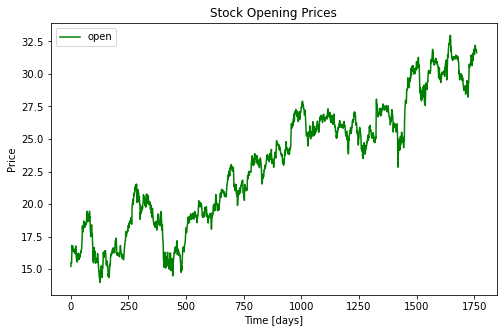

In [134]:
plt.figure(figsize=(8, 5));

plt.plot(df[df.symbol == 'GE'].open.values, color='green', label='open')
plt.title('Stock Opening Prices')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

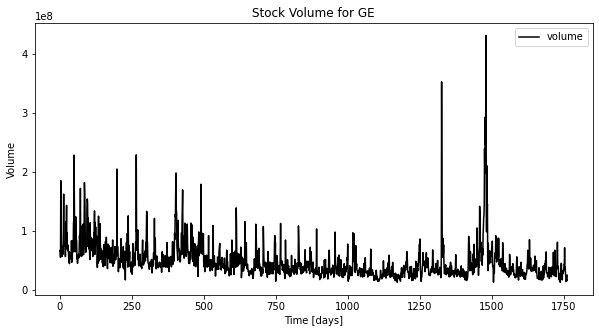

In [135]:
plt.figure(figsize=(10, 5));

plt.plot(df[df.symbol == 'GE'].volume.values, color='black', label='volume')
plt.title('Stock Volume for GE')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best');

In [10]:
#Normalizing close prices

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [11]:
df.drop(['date'],1,inplace=True)

In [12]:
# Perfoming train test for a single stock:

def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(10/100*data.shape[0]));  
    test_set_size = int(np.round(10/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    X_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    X_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    X_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

In [13]:
# choosing one stock
df_stock = df[df.symbol == 'GE'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

seq_len = 50 
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(df_stock_norm, seq_len)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
X_train.shape =  (1370, 49, 4)
y_train.shape =  (1370, 4)
X_valid.shape =  (171, 49, 4)
y_valid.shape =  (171, 4)
X_test.shape =  (171, 49, 4)
y_test.shape =  (171, 4)


## Task 1 (60 points)

### Part 1 (35 points): Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model (NOTE: Performance should be measured both for the validation set and the test set).

In [14]:
#Practicing building a simple RNN

model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               24704     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 89,994
Trainable params: 89,994
Non-trainable params: 0
_________________________________________________________________


In [15]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(X_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, X_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > X_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return X_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 200 
n_outputs = 4
n_layers = 2 
learning_rate = 0.0001
batch_size = 50
n_epochs = 100
train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

# run model
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) 
        
        # fetch the next training batch 
        
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: X_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: X_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: X_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: X_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: X_test})
    

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/opt/anaconda3/lib/python3.8/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:415: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/opt/anaconda3/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `

0.00 epochs: MSE train/valid = 0.168493/0.528675
5.00 epochs: MSE train/valid = 0.000916/0.002918
10.00 epochs: MSE train/valid = 0.000675/0.002071
15.00 epochs: MSE train/valid = 0.000566/0.001373
20.00 epochs: MSE train/valid = 0.000471/0.001267
25.00 epochs: MSE train/valid = 0.000419/0.001103
30.00 epochs: MSE train/valid = 0.000374/0.000956
35.00 epochs: MSE train/valid = 0.000341/0.000913
40.00 epochs: MSE train/valid = 0.000316/0.000881
45.00 epochs: MSE train/valid = 0.000294/0.000807
50.00 epochs: MSE train/valid = 0.000294/0.000902
55.00 epochs: MSE train/valid = 0.000262/0.000786
60.00 epochs: MSE train/valid = 0.000257/0.000813
65.00 epochs: MSE train/valid = 0.000241/0.000770
70.00 epochs: MSE train/valid = 0.000260/0.000859
75.00 epochs: MSE train/valid = 0.000234/0.000637
80.00 epochs: MSE train/valid = 0.000211/0.000679
85.00 epochs: MSE train/valid = 0.000209/0.000700
90.00 epochs: MSE train/valid = 0.000208/0.000727
95.00 epochs: MSE train/valid = 0.000196/0.000657


### Part 2 (25 points): Update your network from part 1 with either an LSTM or a GRU based cell structure. Re-do the training and performance evaluation. What are the major differences you notice? Why do you think those differences exist between the 2 implementations? 

In [16]:
#Updating the above code for LSTM

## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(X_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, X_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > X_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return X_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 200 
n_outputs = 4
n_layers = 2 
learning_rate = 0.0001
batch_size = 50
n_epochs = 100
train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# Using LSTM Now
layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True)
          for layer in range(n_layers)]

multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

# run
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: X_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: X_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: X_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: X_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: X_test})
    


/opt/anaconda3/lib/python3.8/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "


0.00 epochs: MSE train/valid = 0.212838/0.642925
5.00 epochs: MSE train/valid = 0.002131/0.011916
10.00 epochs: MSE train/valid = 0.001540/0.004692
15.00 epochs: MSE train/valid = 0.001105/0.002487
20.00 epochs: MSE train/valid = 0.000962/0.002060
25.00 epochs: MSE train/valid = 0.000837/0.002454
30.00 epochs: MSE train/valid = 0.000774/0.001849
35.00 epochs: MSE train/valid = 0.000710/0.002527
40.00 epochs: MSE train/valid = 0.000651/0.002143
45.00 epochs: MSE train/valid = 0.000628/0.002182
50.00 epochs: MSE train/valid = 0.000582/0.001980
55.00 epochs: MSE train/valid = 0.000553/0.001873
60.00 epochs: MSE train/valid = 0.000567/0.001174
65.00 epochs: MSE train/valid = 0.000499/0.001492
70.00 epochs: MSE train/valid = 0.000485/0.001753
75.00 epochs: MSE train/valid = 0.000464/0.002065
80.00 epochs: MSE train/valid = 0.000434/0.002276
85.00 epochs: MSE train/valid = 0.000442/0.000915
90.00 epochs: MSE train/valid = 0.000423/0.002329
95.00 epochs: MSE train/valid = 0.000382/0.001842


## Task 2 (40 points):
In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link provided with the lecture notes can be useful to get started. Write your own code/function that uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of words (read as user input). The dissimilarity score should be defined by you. You either can have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In either case clearly describe how this score helps determine the dissimilarity between 2 words.
Note: Dissimilarity measure has been an important metric for recommender systems trying to introduce ‘Novelty and Diversity’ in assortments (as opposed to only accuracy). You might find different metrics of dissimilarity in recommender system’s literature.

In [2]:
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec
model = Word2Vec(lee_corpus_list, vector_size=24, epochs=100)
word_vectors = model.wv

In [3]:
word_vectors['man', 'woman']

array([[-1.00229405e-01, -4.27174187e+00,  3.21078253e+00,
        -4.24728107e+00,  4.40263128e+00,  1.99716938e+00,
        -5.20065539e-02,  1.51649749e+00,  3.65094328e+00,
        -2.44903040e+00, -7.05892920e-01, -1.91801298e+00,
        -2.30222917e+00,  6.95097506e-01,  3.07540965e+00,
         6.35644674e-01, -1.48988605e-01, -1.34135234e+00,
        -6.02009833e-01,  7.72598207e-01,  1.20790577e+00,
         1.58368990e-01,  5.98071992e-01,  6.81189120e-01],
       [-4.42087084e-01, -1.31256592e+00, -1.00263095e+00,
        -1.48211026e+00, -3.54664683e-01,  1.47096574e+00,
         2.69288898e-01, -2.05164343e-01,  1.44135952e+00,
         5.50505459e-01, -1.54656494e+00, -1.49453330e+00,
        -3.68598461e-01,  2.26339161e-01, -6.72873139e-01,
         7.29661360e-02,  4.77382571e-01, -4.10031825e-01,
         9.81033921e-01,  3.13160300e-01,  3.88025632e-03,
         1.00110924e+00,  1.19601500e+00,  1.06361061e-01]], dtype=float32)

In [4]:
def cosine_similarity(a,b):

    # Using dot product definition of cosine similarity:
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [8]:
cosine_similarity(word_vectors['man'], word_vectors['woman'])

0.37574515

In [9]:
def cosine_dissimilarity(a, b):
    return 1 - cosine_similarity(a,b)

In [10]:
cosine_dissimilarity(word_vectors['man'], word_vectors['woman'])

0.6242548525333405

In [11]:
cosine_similarity(word_vectors['man'], word_vectors['woman'])

0.37574515

User input for calculating cosine similarity and dissimilarity

In [15]:
cosine_similarity(word_vectors[(input("Enter word 1: "))], word_vectors[(input("Enter word 2: "))])

Enter word 1: man
Enter word 2: woman


0.37574515

In [16]:
cosine_similarity(word_vectors[(input("Enter word 1: "))], word_vectors[(input("Enter word 2: "))])

Enter word 1: tree
Enter word 2: man


0.108120576

In [17]:
cosine_dissimilarity(word_vectors[(input("Enter word 1: "))], word_vectors[(input("Enter word 2: "))])

Enter word 1: man
Enter word 2: woman


0.6242548525333405

In [18]:
cosine_dissimilarity(word_vectors[(input("Enter word 1: "))], word_vectors[(input("Enter word 2: "))])

Enter word 1: tree
Enter word 2: man


0.8918794244527817

In the above code I used Word2Vec to train on the lee corpus data. Next I defined the cosine similarity function as a dot product of the 2 inputs divided by the normalized product if the same 2 inputs. Later I defined dissimilarity score as a flipped version of similarity score which is simply 1-cosine similarity. 